In [1]:
# Fed wants 7000 sq degrees, in 3 filters, with 2 epochs
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles


In [2]:
# Add an extinction cut
class Well_covered(metrics.BaseMetric):
    """
    
    """
    def __init__(self,nfilters=3, nepoch=2, filterCol='filter',
                nightCol='night', **kwargs):
        """
        
        """
        self.filterCol = filterCol
        self.nightCol = nightCol
        col = [self.filterCol, self.nightCol]
        super(Well_covered, self).__init__(col=col, **kwargs)
        self.nepoch = nepoch
        self.nfilters = nfilters

    def run(self, dataSlice, slicePoint=None):
        """
        
        """
        result = 0
        ufilters = np.unique(dataSlice[self.filterCol])
        enough_epochs = np.zeros(ufilters.size)
        for i,filtername in enumerate(ufilters):
            in_filt = np.where(dataSlice[self.filterCol] == filtername)
            n_epoch = np.size(np.unique(dataSlice[self.nightCol][in_filt]))
            if n_epoch >= self.nepoch:
                enough_epochs[i] = True
        n_filt_w_epochs = np.sum(enough_epochs)
        if n_filt_w_epochs >= self.nfilters:
            result = 1
        
        return result

In [3]:
dbFile = 'baseline_v1.3_10yrs.db'
# This connection checks which version it thinks the database is and should do the right thing schema-wise
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [4]:
nside = 128
bundleList = []
sql = 'night < 30'
metric = Well_covered()
slicer = slicers.HealpixSlicer(nside=nside)
plotDict = {} #{'colorMax': 27.4}
summary = []
summary.append(metrics.SumMetric())

bundleList.append(metricBundles.MetricBundle(metric,slicer,sql, plotDict=plotDict, summaryMetrics=summary))

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


Querying database SummaryAllProps with constraint night < 30 for columns ['fieldRA', 'night', 'fieldDec', 'filter']
Found 21753 visits
Running:  ['opsim_Well_covered_filter_night_night_lt_30_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night < 30" constraint now.
monopole: -0.101586  dipole: lon: -0.015942, lat: -23.5628, amp: 1.11476
Plotting complete.


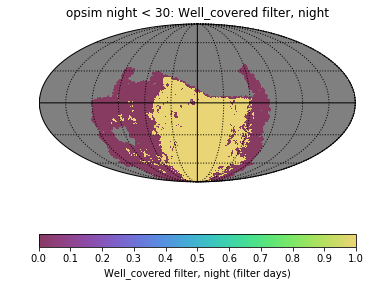

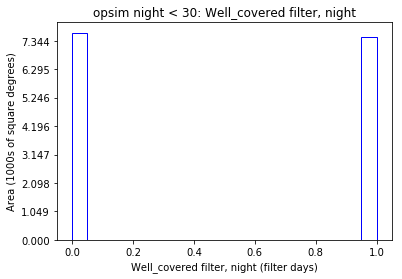

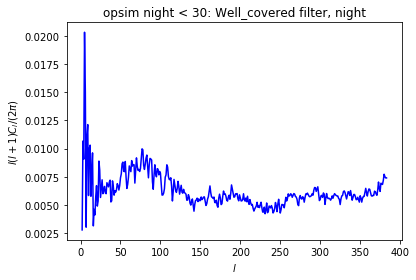

In [5]:

bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

bg.plotAll(closefigs=False)

In [6]:
pix_area = hp.nside2pixarea(nside, degrees=True)


In [7]:
area_covered = bundleList[0].summaryValues['Sum']*pix_area
print('Area covered = %.2f sq degrees' % area_covered)

Area covered = 7469.29 sq degrees
